In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [2]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(in_features=512, out_features=2)
    
    def forward(self, x):
        return self.backbone(x)


In [ ]:
def load_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)
    return image


In [13]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradient = None
        self.activation = None

        # Hook for the activations
        def get_activation(module, input, output):
            self.activation = output.detach()
        
        # Hook for the gradients
        def get_gradient(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Register hooks
        self.model.backbone.layer4[1].conv2.register_forward_hook(get_activation)
        self.model.backbone.layer4[1].conv2.register_backward_hook(get_gradient)

    def generate_heatmap(self, input_image, class_idx):
        self.model.eval()
        output = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        # Weighted sum of gradients and activations
        pooled_gradients = torch.mean(self.gradient, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(self.activation, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy()

def apply_heatmap(heatmap, original_image, alpha=0.9):
    heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    original_image = np.array(original_image)
    superimposed_img = heatmap * alpha + original_image
    return superimposed_img / superimposed_img.max()


In [ ]:
def plot_images(original_img, superimposed_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(superimposed_img)
    ax[1].set_title('Image with GradCAM')
    ax[1].axis('off')
    
    plt.show()


/var/folders/_k/p456ysf97055480wnwcst5gm0000gn/T/ipykernel_6234/322830841.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/Users/himanshu_mac/Wo

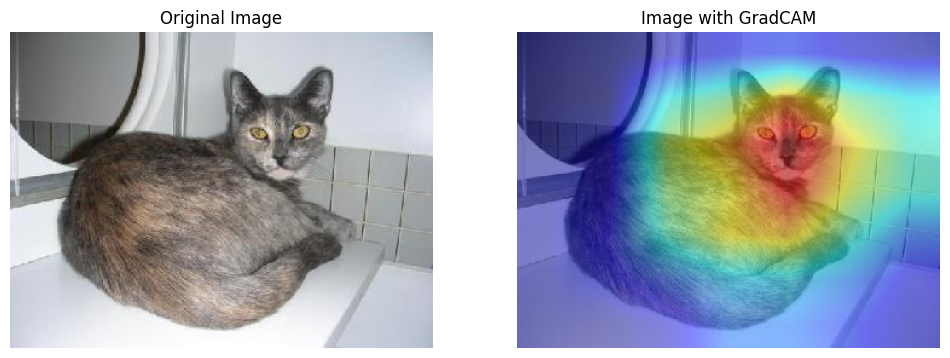

In [17]:
model = ClassificationModel()
checkpoint = torch.load("/Users/himanshu_mac/Workspace/self_projects/GradCam_on_dog_Vs_cat/best_model.pth")

model.load_state_dict(checkpoint)
grad_cam = GradCAM(model)

path = "/Users/himanshu_mac/Workspace/self_projects/GradCam_on_dog_Vs_cat/kagglecatsanddogs_3367a/PetImages/Cat/30.jpg"
image = load_image(path)

heatmap = grad_cam.generate_heatmap(image, class_idx=None)  # class_idx=None for the highest probability class

original_image = Image.open(path).convert('RGB')

superimposed_img = apply_heatmap(heatmap, original_image)

plot_images(original_image, superimposed_img)
